# Week 3 CNN Cancer Detection Kaggle Mini-Project


## Step1: Brief description of the problem and data

For this mini-project, we will be creating an algorithm to identify metastatic cancer by examining image patches from larger digital pathology scans. We will accomplish this task by utilizing a convolutional neural network (CNN), a feed-forward neural network that learns feature engineering. We will compare this model to a slightly deeper CNN and a forward feed neural network (FNN).
<br>
<br>
The data came from this kaggle competition: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data.
<br>
<br>
The dataset contains small pathology images labeled with image IDs. The goal is to predict if the central 32x32px patch of an image contains tumor tissue. The dataset has no image duplicates, unlike the original version. There are a total of 277485 image files which take up 7.76 GB of storage. The images have been split into a test set and a training set. The dataset also includes two csv files "sample_submission.csv" and "train_labels.csv". These give you an example of how the submission file should be formatted and the labels for the training data, respectively. 
<br>

## Step 2: Exploratory Data Analysis (EDA) — Inspecting, Visualizing, and Cleaning our Data

<br>
The first thing we will do is import the data into a dataframe. We will examine the head, count the features, and see if there are any oppurtunities for data cleaning procedures. 

### Inspection
The first thing we will do is import all the libraries we will use for this project, load the data, and examine the dataframe heads.

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import RandomizedSearchCV


train_labels = pd.read_csv("train_labels.csv")
sample_submission = pd.read_csv("sample_submission.csv")

print(train_labels.head())
print(sample_submission.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0


### Visualization
Next let's look at the distribution of the labels and see if the dataset is unbalanced. Then we will take a look at some of the images, just to get a good idea of the images' structure and appearance. 

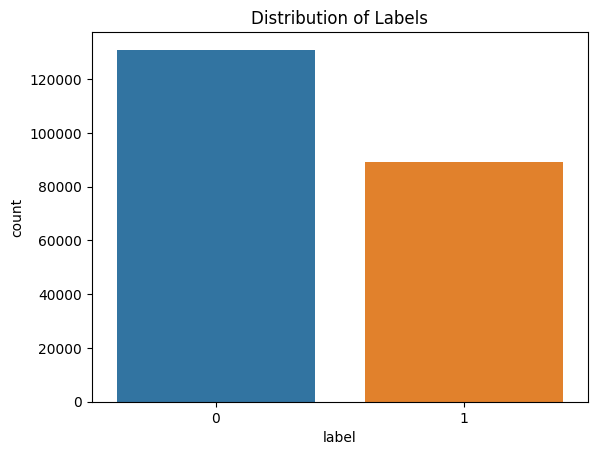

In [2]:
sns.countplot(x="label", data=train_labels)
plt.title("Distribution of Labels")
plt.show()

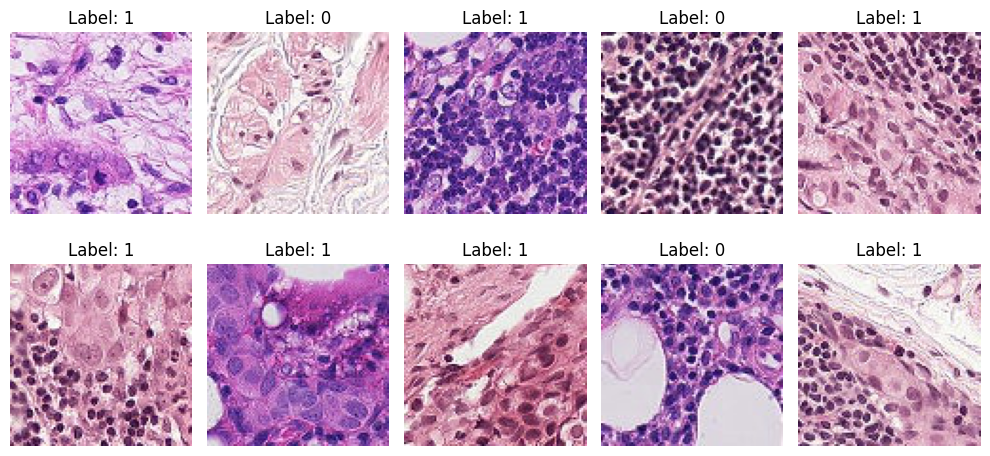

In [3]:
def visualize_images(image_ids, labels):
    plt.figure(figsize=(10,5))
    for index, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(2, 5, index + 1)
        image = Image.open(f"train/{image_id}.tif")
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

sample_data = train_labels.sample(10)
visualize_images(sample_data["id"], sample_data["label"])

### Cleaning
Now, let's see if there are any oppurtunities for cleaning! We will simply check for any missing values in "train_labels".

In [4]:
missing_values = train_labels.isnull().sum()
print(missing_values)

id       0
label    0
dtype: int64


### Summary of EDA 
A relatively simple and successful EDA. The distribution of labels is slightly skewed, but it will not be a problem for our purposes. Viewing the images in the dataset, while interesting, turned out to be less insightful than I thought. It's not blatantly obvious how to tell healthy cells from cancerous ones (at least to someone untrained like myself). And thankfully, trimming the dataset is not needed, as there are no missing values in train_labels. <br><br> 
For the next step, we will construct our CNN!

## Step 3: Model Architecture



### Reasoning for Model Selection
The CNN is a neural network that performs very well in image classification tasks. This is due to localized feature detection, which essentially means it can discern edges, textures, corners, etc. This feature is key, because just looking at our sample images show a remakable degree of similarity in our pictures. <br> The other two models that we will look at are a deeper CNN model and an FNN model. This is due to the very large nature of our dataset. I decided to run a slightly deeper CNN in tandum to compare the results of our more basic one. The FNN was chosen because it is simple, lightweight, and relatively effecient. 

### Model Construction
The first model we will make is our CNN, which we will name "model". This model has an input layer of 96,96,3 (our image shape). This is followed by a max pooling layer, which reduces the dimensions of the output in half. We then have two convolution layers followed by two more max pooling layers. We then flatten our output into a 1D vector and then connect to a fully connected dense layer with 512 neurons. Finally, we have our output layer that has a single neuron (0 or 1) and uses a sigmoid activation to output. We then compile our model using the optimizer Adam (a standard gradient optimization algorithm), loss function binary crossentropy, and metrics are set to accuracy.

In [5]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Alternate Models Construction
Let's briefly go over the construction of our alternative models! <br><br>
Our first model is very simple to explain, as it's the same model as the one above. The only difference is that there is an added convolution layer and max pooling. Notice that this added layer has 256 neurons. Everything else has stayed the same. <br><br>
Our FNN model is much simpler than our other two. It has one input layer, three dense layers of decreasing neuron amounts, and an output layer (that is the same as our CNN models). Both alternative models are compiled with the same optimizers, loss values, and metrics as our CNN model.

In [6]:
deeper_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  
])

deeper_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
fnn_model = Sequential([
    Flatten(input_shape=(96, 96, 3)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

fnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Data Loading
Now that our models are done, it is time to prepare our image data! In order to do this, we have made two data generators: train_generator and val_generator. This will be used for training and validation respectively. How it works is that the generators will feed batches of images and their labels to one of our neural networks during training, with images being augmented and normalized during the process. Augmentation and normalization is critical to this problem set because it helps the models generalize better to unseeen data, it can improve accuracy, and it can help prevent model saturation.

In [8]:
BATCH_SIZE = 64
IMG_SIZE = (96, 96)

train_df = pd.read_csv('train_labels.csv')
train_df['id'] = train_df['id'].astype(str) + '.tif'
train_df['label'] = train_df['label'].astype(str)

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                                   rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.1,
                                   zoom_range=0.2, horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    directory='train',
                                                    x_col='id',
                                                    y_col='label',
                                                    subset='training',
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary')

val_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                  directory='train',
                                                  x_col='id',
                                                  y_col='label',
                                                  subset='validation',
                                                  target_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='binary')


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### Train Model and Generate CSV for Kaggle
We are now ready to train our models! Each model will be using 'train_generator' as their training set, and will be validated on 'val_generator'. Each model will then be trained for 5 epochs and saved to a history object. Just beware: because of the size of the dataset, this will take a very, very long time if you don't have tensorflow-gpu or something equivalent set up (my advice, just let it run overnight). <br> Once that is completed, we will then put our predicted labels into a csv file and upload our results to Kaggle.

In [9]:
model_history = model.fit(train_generator, validation_data=val_generator, epochs=5)
deeper_history = deeper_model.fit(train_generator, validation_data=val_generator, epochs=5)
fnn_history = fnn_model.fit(train_generator, validation_data=val_generator, epochs=5)

Epoch 1/5
2751/2751 [==============================] - 2212s 804ms/step - loss: 0.4352 - accuracy: 0.8015 - val_loss: 0.3859 - val_accuracy: 0.8329
Epoch 2/5
2751/2751 [==============================] - 681s 247ms/step - loss: 0.3568 - accuracy: 0.8454 - val_loss: 0.3288 - val_accuracy: 0.8596
Epoch 3/5
2751/2751 [==============================] - 524s 190ms/step - loss: 0.3206 - accuracy: 0.8640 - val_loss: 0.3101 - val_accuracy: 0.8689
Epoch 4/5
2751/2751 [==============================] - 756s 275ms/step - loss: 0.2984 - accuracy: 0.8744 - val_loss: 0.3022 - val_accuracy: 0.8759
Epoch 5/5
2751/2751 [==============================] - 470s 171ms/step - loss: 0.2816 - accuracy: 0.8828 - val_loss: 0.2681 - val_accuracy: 0.8907
Epoch 1/5
2751/2751 [==============================] - 501s 182ms/step - loss: 0.4316 - accuracy: 0.8043 - val_loss: 0.3657 - val_accuracy: 0.8384
Epoch 2/5
2751/2751 [==============================] - 771s 280ms/step - loss: 0.3474 - accuracy: 0.8494 - val_loss: 

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(directory='test', class_mode=None, target_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)

predictions = model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

submission = pd.DataFrame({"id": [os.path.basename(f).split('.')[0] for f in test_generator.filenames], "label": predicted_labels})
submission.to_csv("basic_cnn_submission.csv", index=False)

Found 57458 images belonging to 1 classes.
898/898 [==============================] - 239s 266ms/step


## Step 4: Results and Analysis



### Initial Results
Let's take a look at the results! We will first observe the training loss/accuracy and the validation loss/accuracy for each model's final epoch. Then, we will plot each model's performance across each epoch. Then we will discuss our preliminary results.

In [33]:
def print_final_epoch_stats(history, model_name):
    final_train_loss = history.history['loss'][-1]
    final_train_accuracy = history.history['accuracy'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]

    print(f"{model_name} Final Epoch Stats:")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Training Accuracy: {final_train_accuracy:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print(f"Validation Accuracy: {final_val_accuracy:.4f}")
    print("-"*40)

print_final_epoch_stats(model_history, "Model")
print_final_epoch_stats(deeper_history, "Deeper Model")
print_final_epoch_stats(fnn_history, "FNN Model")

Model Final Epoch Stats:
Training Loss: 0.2816
Training Accuracy: 0.8828
Validation Loss: 0.2681
Validation Accuracy: 0.8907
----------------------------------------
Deeper Model Final Epoch Stats:
Training Loss: 0.2796
Training Accuracy: 0.8846
Validation Loss: 0.3142
Validation Accuracy: 0.8677
----------------------------------------
FNN Model Final Epoch Stats:
Training Loss: 0.5701
Training Accuracy: 0.7074
Validation Loss: 0.5548
Validation Accuracy: 0.7191
----------------------------------------


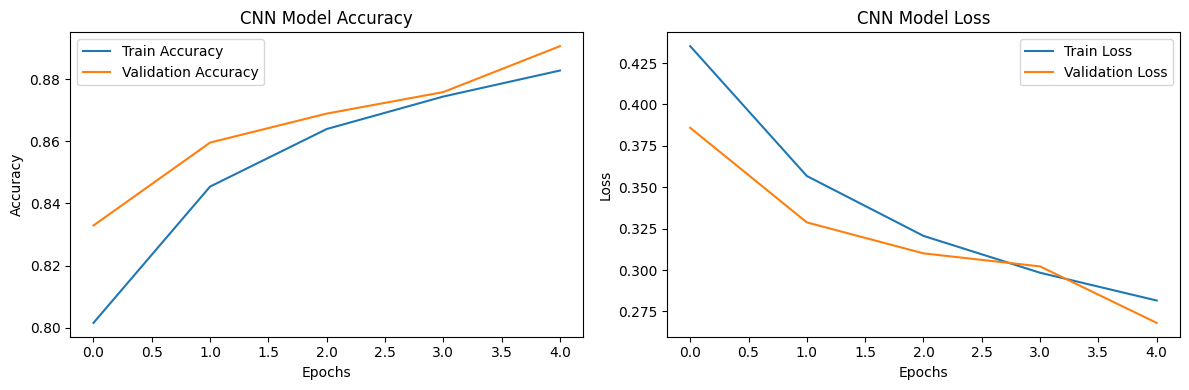

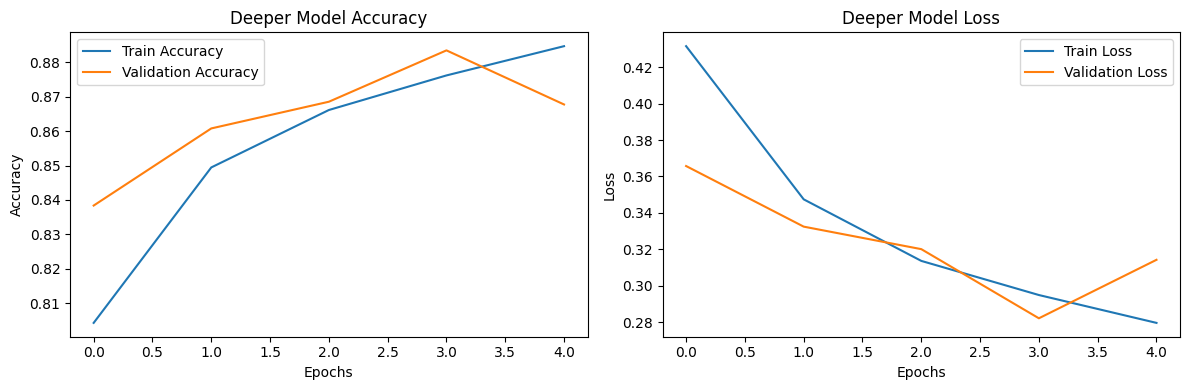

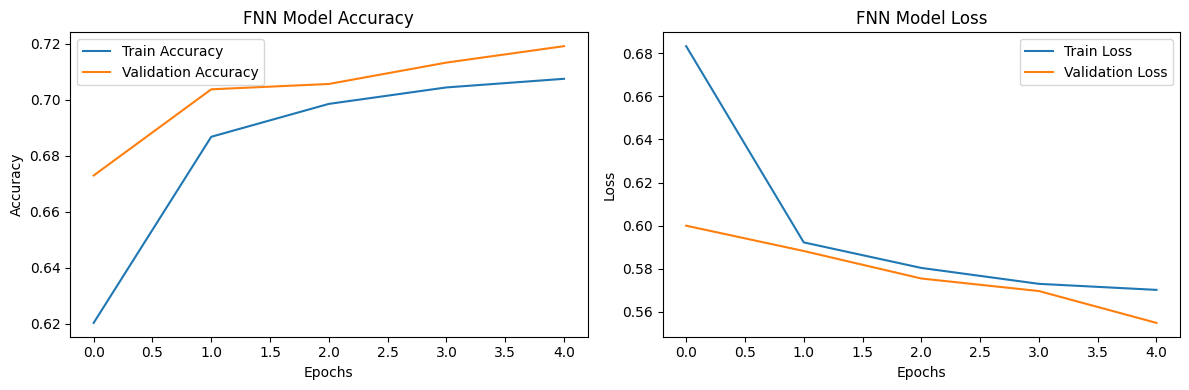

In [34]:
def plot_model_performance(history, title=""):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_model_performance(model_history, "CNN Model")
plot_model_performance(deeper_history, "Deeper Model")
plot_model_performance(fnn_history, "FNN Model")


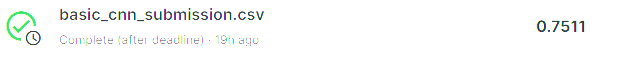

In [43]:
from IPython.display import Image
Image(filename="./basic_cnn_sub.png")

Out of the three models, it appears that our base CNN model performed the best when it comes to generalizing unseen data. This is becuase the CNN model had the highest validation score of 89.07%. Contrary to what I thought, the deeper model performed slightly less well than our base model. We can see that in the last epoch that there was some evidence that overfitting was occuring due to the much higher training accuracy and increased validation loss. As expected, the FNN performed the worst, but it performed much better than I thought! It makes sense, as the FNN did not have convolutional layers, but it held its own at a respectable 71.91% validation accuracy. For our Kaggle submission, we can see from the image above that our score was .7511. This isn't awful, but let's see if we can do better.

### Hyperparameter Tuning & Attempts to Improve Performance
Let's try to make our CNN even better! We can do this by tuning our hyper parameters. We will utilize keras tuner's RandomSearch method to help us in this task. This code will take our base CNN model and use different hyperparameter combinations in order to identify the best possible model. 

In [29]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    model = Sequential()
    
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=16, max_value=64, step=16, default=32),
                     kernel_size=hp.Choice('conv_1_kernel', values = [3], default=3),
                     activation='relu',
                     input_shape=(96, 96, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=32, default=64),
                     kernel_size=hp.Choice('conv_2_kernel', values = [3], default=3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=hp.Int('conv_3_filter', min_value=64, max_value=256, step=64, default=128),
                     kernel_size=hp.Choice('conv_3_kernel', values = [3], default=3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(units=hp.Int('dense_1_units', min_value=256, max_value=1024, step=256, default=512),
                    activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-4, 1e-3, 5e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=5,
                     directory='output',
                     project_name="HypertuneCNN")

tuner.search(train_generator, epochs=5, validation_data=val_generator)

Trial 5 Complete [01h 07m 28s]
val_accuracy: 0.8838995695114136

Best val_accuracy So Far: 0.8838995695114136
Total elapsed time: 05h 23m 22s
INFO:tensorflow:Oracle triggered exit


### Final Model Performance

In [30]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
optimized_model = tuner.hypermodel.build(best_hyperparameters)
best_history = optimized_model.fit(train_generator, epochs=5,validation_data=val_generator)

predictions_optimized = optimized_model.predict(test_generator)
predicted_labels_optimized = (predictions_optimized > 0.5).astype(int).reshape(-1)

Epoch 1/5
2751/2751 [==============================] - 568s 206ms/step - loss: 0.4586 - accuracy: 0.7885 - val_loss: 0.4164 - val_accuracy: 0.8114
Epoch 2/5
2751/2751 [==============================] - 562s 204ms/step - loss: 0.3825 - accuracy: 0.8315 - val_loss: 0.3479 - val_accuracy: 0.8491
Epoch 3/5
2751/2751 [==============================] - 562s 204ms/step - loss: 0.3412 - accuracy: 0.8520 - val_loss: 0.3303 - val_accuracy: 0.8568
Epoch 4/5
2751/2751 [==============================] - 563s 205ms/step - loss: 0.3153 - accuracy: 0.8653 - val_loss: 0.2981 - val_accuracy: 0.8767
Epoch 5/5
898/898 [==============================] - 242s 270ms/step


In [31]:
submission = pd.DataFrame({"id": [os.path.basename(f).split('.')[0] for f in test_generator.filenames], "label": predicted_labels_optimized})
submission.to_csv("optimized_cnn_submission.csv", index=False)

CNN Model Final Epoch Stats:
Training Loss: 0.2816
Training Accuracy: 0.8828
Validation Loss: 0.2681
Validation Accuracy: 0.8907
----------------------------------------
Tuned Model Final Epoch Stats:
Training Loss: 0.2936
Training Accuracy: 0.8756
Validation Loss: 0.3253
Validation Accuracy: 0.8633
----------------------------------------


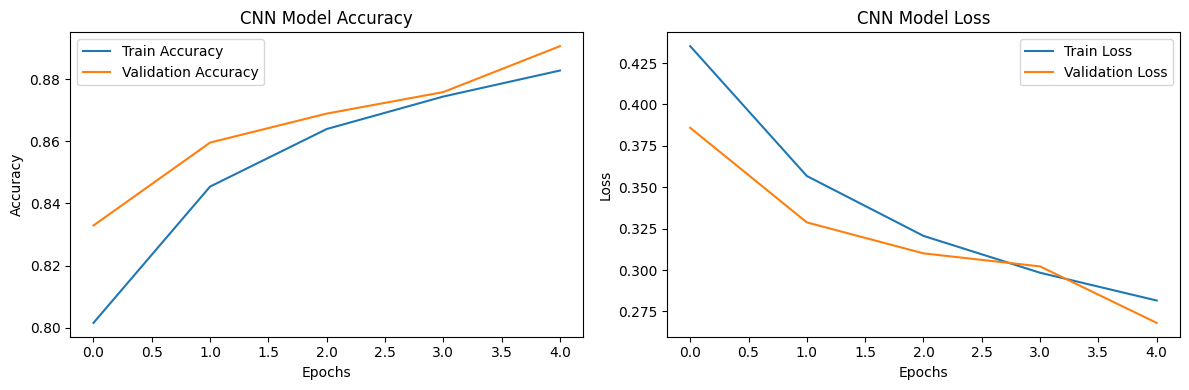

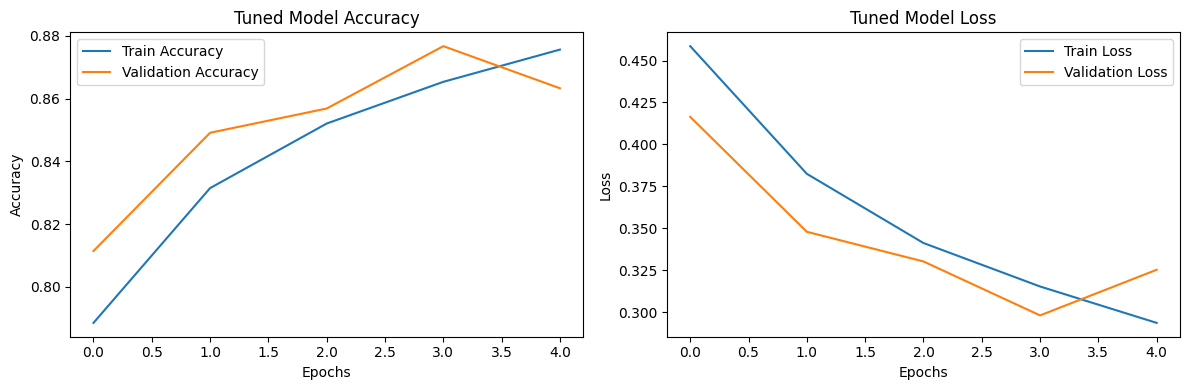

In [38]:
print_final_epoch_stats(model_history, "CNN Model")
print_final_epoch_stats(best_history, "Tuned Model")
plot_model_performance(model_history, "CNN Model")
plot_model_performance(best_history, "Tuned Model")

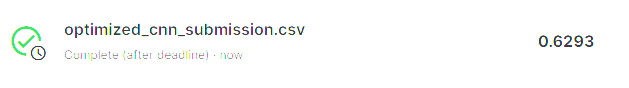

In [45]:
Image(filename="./optimized_cnn_sub.png")

Unfortunately, it does not appear that our tuning process was a success. The original model outperforms the tuned model on almost every metric. Additionally, our Kaggle submission dropped by nearly 10 points! So what happened? <br>
Well, hyperparameter tuning can sometimes be a roll of the dice and this time I was not so lucky. The success of the random search is really reliant on the size of the search space, number of trials, etc. Given the scope of the dataset, this was not the most feasible thing to accomplish. This is why the model appears to be overfitting and not performing well on our validation set or Kaggle datasets.

## Step 5: Conclusion



Overall, I would say that this project was a good way to learn about the importance of CNNs, the frustrations of very large datasets, and the pitfalls of hyperparameter tuning. CNNs are a great way to classifiy images quick and reliably. And just because a model might be more complex or deep does not guarantee better results (and in this case even be slightly worse). <br> There are many things I would do differently in the future. The first thing I would do would be to get off my lazy butt and finally install GPU integration for tensorflow. Especially in this case, the utilization of a GPU would have made my model creation much faster. This could have lead me to do more fine-tuning, adjusting, parameter optimization, etc. Additionally, in order to increase performance, I may implement learning rate scheduling and early stopping. This may increase performance and cut down on the project being computationally expensive.